# AOTY 2019
It's that time of year again where album of the year is done and I throw around a series of graphs for no real reason. Let's get started.

### Setting up the environment
First we need to set up our environment. There's only a few modules we need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
%matplotlib inline

### Importing the data
First, we need to import the data. This __won't be uploaded here__, so you'll have to ask [Pip](https://www.twitter.com/philipcopley) nicely for a copy if you want to do anything with it. We're also going to process it... quite a bit, to get it into a nice format to play with:
- Drop the total column so we can calculate our own
- Drop any empty rows or columns that we've accidentally grabbed from Excel
- Make sure we don't have any duplicate Artist rows
- Count the number of lists each album has appeared in

In [2]:
df = pd.read_excel('AOTY.xlsx', sheet_name='Albums')\
       .drop('TOTAL', axis=1)\
       .reset_index()\
       .rename(columns={'index': 'Artist'})\
       .dropna(axis=0, subset=['Artist'])\
       .dropna(axis=1, how='all')\
       .dropna(axis=0, how='all')\
       .fillna(0)\
       .groupby('Artist').sum()

df = df[sorted(df.columns)]
df['Total'] = df.sum(axis=1, numeric_only=True)
df['Inclusions'] = df[[c for c in df.columns if c != 'Total']].astype(bool).sum(axis=1)

### Getting the Top 20
We're going to graph the top 20 a lot. So let's pull them out to work with, and sort at the same time.

In [3]:
top_20 = df.sort_values(by='Total', ascending=False)[:20]

### Total Scores
The most simple graph we can do is a bar chart of the top 20.

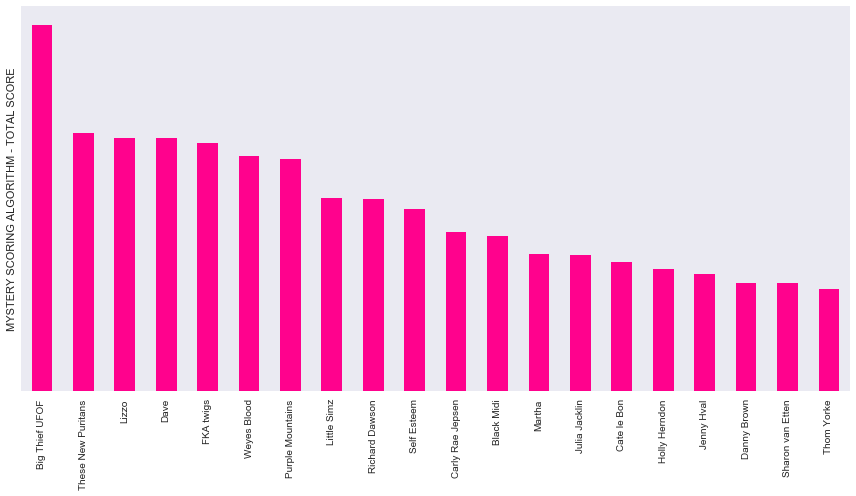

In [4]:
ax = top_20.plot.bar(y='Total', legend=False, figsize=(12,7), color='xkcd:hot pink')
ax.set(yticks=[], ylabel='MYSTERY SCORING ALGORITHM - TOTAL SCORE', xlabel='')
ax.grid(visible=False)
plt.tight_layout()
plt.savefig(r'Graphs\01 Total Score.png', bbox_inches='tight')

It's impressive here just how far ahead Big Thief's album is. The next 4 albums in the list are all relatively tight, and the it starts to tail off, to the eztent that the 10th album in the list has less than half the score of the top one.

### Score Distributions
Now things start getting a little more complicated - how are scores for the top 20 distributed? Are they coming up because they're liked by lots of people, or loved by a handful of committed fans? 

First what we'll do is get just the individual scores for each album on the lists they appear on. Then, we can show the data nicely with a box plot.

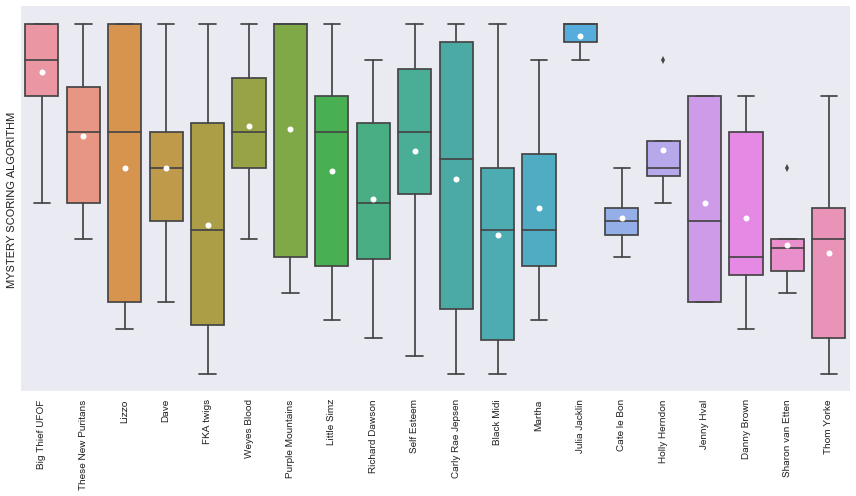

In [5]:
pvt = top_20.drop(['Total', 'Inclusions'], axis=1).stack().reset_index()
pvt.columns = ['Artist', 'Reviewer', 'Score']
pvt = pvt[(pvt['Score'] > 0)]

fig, ax = plt.subplots(figsize=(12, 7))
ax = sns.boxplot(x=pvt['Artist'], y=pvt['Score'], showmeans=True,
                meanprops=dict(marker='o', markerfacecolor='white'))
ax.set(yticks=[], ylabel='MYSTERY SCORING ALGORITHM', xlabel='')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(r'Graphs\02 Score Distributions.png', bbox_inches='tight')

What's interesting here is the inconsistent profile of the averages - we can see, for example, that FKA twigs actually has a fairly low average rating, but seemingly has appeared on a lot of lists, resulting in its high placement. On the other hand, Julia Jacklin has the highest average rating of all of the top 20 but is only placed at 14th - seemingly from appearing on a small number of lists. We can take a look at this.

### Number of List Inclusions
We've already got all the information we need to make this graph from our `top_20` frame

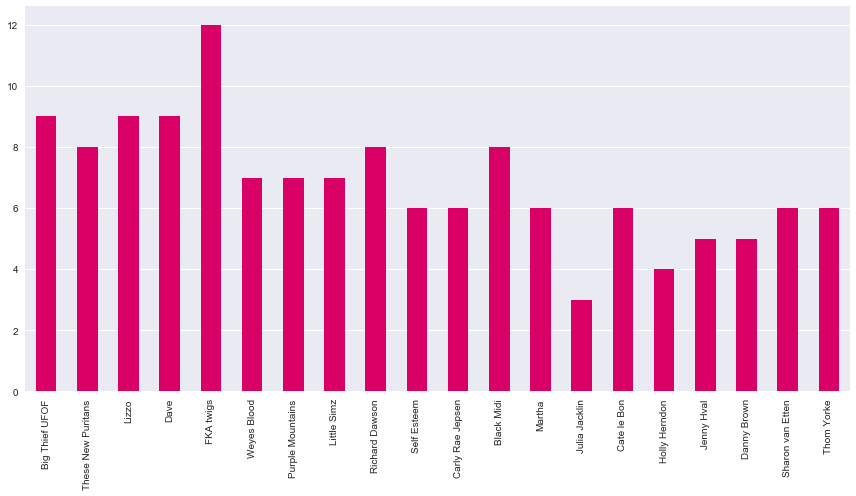

In [6]:
ax = top_20.plot.bar(y='Inclusions', legend=False, figsize=(12,7), color='xkcd:dark hot pink')
ax.set(xlabel='')
ax.grid(visible=False, axis='x')
plt.tight_layout()
plt.savefig(r'Graphs\03 Inclusions.png', bbox_inches='tight')

Julia Jacklin making the top 20 despite appearing on only 3 lists is quite the impressive feat. Unsurprisingly, FKA twigs appeared on the most lists of the top 20.

### Similar Tastes
We might also want to consider who of the AOTY participants had the most similar lists. To do this, we make a correlation matrix showing the correlation between each person. This will be symmetrical, so we will just take the uppper half of it ad then stack it into a column. Then we can pick out the top ten people with similar tastes.

In [7]:
person_corr = df.drop(['Total', 'Inclusions'], axis=1).corr()

# Name the index and columns - it'll help later
person_corr.index.name = 'Person 1'
person_corr.columns.name = 'Person 2'

person_results = person_corr.mask(np.tril(np.ones(person_corr.shape)).astype(bool)).stack()

person_results.name = 'Correlation'
person_results = person_results.reset_index()\
                               .sort_values(by='Correlation', ascending=False)\
                               .reset_index(drop=True)\
                               .head(10)
person_results

,Person 1,Person 2,Correlation
0,Joe,Sarge,0.762126
1,J Boll,Sarge,0.584830
2,Cal,Kev,0.490229
3,BLS,Cal,0.480128
4,Cal,MCL,0.477507
5,Charles,Joe,0.457502
6,Charles,Sarge,0.454159
7,Benny,C Boll,0.453088
8,LBW,Sarge,0.430852
9,Kev,MCL,0.428637


### Similar Albums
Similarly, we can consider which albums have tended to appear in lists together. The slight issue here is that there will be some albums that have only appeared on one list, meaning they'll necessarily have a correlation of 1. To avoid this, we'll first filter to select only albums that have appeared on more than 3 lists.

In [8]:
album_corr = df[df['Inclusions'] > 3].drop(['Total', 'Inclusions'], axis=1).transpose().corr()

# Name the index and columns - it'll help later
album_corr.index.name = 'Album 1'
album_corr.columns.name = 'Album 2'

album_results = album_corr.mask(np.tril(np.ones(album_corr.shape)).astype(bool)).stack()

album_results.name = 'Correlation'
album_results = album_results.reset_index()\
                             .sort_values(by='Correlation', ascending=False)\
                             .reset_index(drop=True)\
                             .head(10)
album_results

,Album 1,Album 2,Correlation
0,Nick Cave,Sharon van Etten,0.729949
1,Lana del Rey,Self Esteem,0.702174
2,Carly Rae Jepsen,Martha,0.697543
3,Danny Brown,Jai Paul,0.650949
4,Angel Olsen,Weyes Blood,0.639361
5,Little Simz,Solange,0.631816
6,Big Thief UFOF,Weyes Blood,0.619851
7,Lizzo,Sharon van Etten,0.572022
8,Black Midi,Solange,0.539988
9,Holly Herndon,Jenny Hval,0.518521
